In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import pandas as pd
import ee
from tqdm import tqdm
from dateutil.relativedelta import relativedelta
from output_utils import plot_heatmap_on_map
import numpy as np
import hopsworks

ee.Authenticate()
ee.Initialize()

import geopandas
from download_utils import download_monthly_ndvi, era5_grid_to_points_df

In [4]:
save = False


# Overview
This notebook is run every 16 days. NDVI data is downloaded over 16 day periods.

# Download NDVI data

In [5]:
end = pd.Timestamp.today().normalize()
start = end.replace(day=1) - relativedelta(months=2)

months = [
    (end - pd.DateOffset(months=i)).replace(day=1).normalize()
    for i in range(3)
]
months

[Timestamp('2026-01-01 00:00:00'),
 Timestamp('2025-12-01 00:00:00'),
 Timestamp('2025-11-01 00:00:00')]

### Prepare dataframe of points to sample NDVI values from

In [6]:
# months_df = pd.DataFrame({"Month": pd.to_datetime(months)})
# months_df["Month"] = pd.to_datetime(months_df["Month"].dt.date)
# months_df["key"] = 1

era5_points_df = pd.read_csv('../data/country/era5coords_df.csv')
print(f"Era5Land Sweden has {len(era5_points_df)} coordinates")
# era5_points_df["key"] = 1
# era5_points_df = era5_points_df.merge(months_df, on="key").drop(columns="key")
era5_points_df

Era5Land Sweden has 7956 coordinates


,row_id,Lat,Lon
0,0,69.1,20.6
1,1,69.0,20.1
2,2,69.0,20.2
3,3,69.0,20.3
4,4,69.0,20.4
...,...,...,...
7951,7951,55.4,13.5
7952,7952,55.4,13.6
7953,7953,55.4,13.7
7954,7954,55.4,13.8


In [7]:
# from shapely.geometry import Point

# era5_gdf = geopandas.GeoDataFrame(
#     era5_points_df,
#     geometry=geopandas.points_from_xy(era5_points_df["Lon"], era5_points_df["Lat"]),
#     crs="EPSG:4326"
# )

# url = "https://naturalearth.s3.amazonaws.com/110m_cultural/ne_110m_admin_0_countries.zip"

# world = geopandas.read_file(url)
# sweden = world[world["NAME"] == "Sweden"].to_crs("EPSG:4326")

# era5_sweden = geopandas.sjoin(
#     era5_gdf,
#     sweden[["geometry"]],
#     how="inner",
#     predicate="within"
# ).drop(columns="index_right")

# era5_sweden_df = era5_sweden.drop(columns="geometry")

# era5_sweden_df.to_csv('../data/country/era5coords_df.csv', index=False)

In [8]:
modis = ee.ImageCollection("MODIS/061/MOD13Q1").select("NDVI")

ndvi_df = download_monthly_ndvi(
    dataset=modis,
    points_df=era5_points_df,
    months=months,
    chunk_size=4000
)

ndvi_df = ndvi_df.sort_values(["row_id", "Month"])
ndvi_df

Months: 100%|██████████| 3/3 [00:53<00:00, 17.91s/it]


,row_id,Month,NDVI,Lat,Lon
15912,0,2025-11-01,-0.0289,69.1,20.6
11303,0,2025-12-01,NaN,69.1,20.6
0,0,2026-01-01,NaN,69.1,20.6
15913,1,2025-11-01,-0.0478,69.0,20.1
11304,1,2025-12-01,NaN,69.0,20.1
...,...,...,...,...,...
15910,7954,2025-12-01,NaN,55.4,13.8
7954,7954,2026-01-01,NaN,55.4,13.8
23867,7955,2025-11-01,NaN,55.4,13.9
15911,7955,2025-12-01,NaN,55.4,13.9


### Replace missing NDVI with average from nearby

In [9]:
coord_to_row = {}
for _, row in era5_points_df.iterrows():
    coord_to_row[(row["Lat"], row["Lon"])] = int(row["row_id"])

# Get unique lat/lon values and their step sizes to find neighbors
unique_lats = sorted(era5_points_df["Lat"].unique())
unique_lons = sorted(era5_points_df["Lon"].unique())

lat_step, lon_step = 0.1, 0.1 # ERA5 Land res

# For each None value, find neighboring row_ids and average their NDVI
ndvi_filled = ndvi_df.copy()
ndvi_original = ndvi_df.copy()  # Keep original to avoid modifying while reading

nan_count_before = ndvi_filled["NDVI"].isna().sum()
print(f"NaN count before: {nan_count_before}")

pass1_count = 0
pass2_count = 0
pass3_count = 0

for idx, row in ndvi_filled.iterrows():
    if pd.isna(row["NDVI"]):
        lat = row["Lat"]
        lon = row["Lon"]
        month = row["Month"]
        row_id = row["row_id"]
        
        # Define all 9 cells (3x3 grid, including center)
        neighbor_lats = [lat - lat_step, lat, lat + lat_step]
        neighbor_lons = [lon - lon_step, lon, lon + lon_step]
        
        # Pass 1: Fill using neighboring coordinates (3x3 grid) in the same month
        neighbor_ndvi_values = []
        for n_lat in neighbor_lats:
            for n_lon in neighbor_lons:
                if (n_lat, n_lon) in coord_to_row:
                    neighbor_row_id = coord_to_row[(n_lat, n_lon)]
                    neighbor_ndvi = ndvi_original[
                        (ndvi_original["row_id"] == neighbor_row_id) & 
                        (ndvi_original["Month"] == month)
                    ]["NDVI"].values
                    if len(neighbor_ndvi) > 0 and not pd.isna(neighbor_ndvi[0]):
                        neighbor_ndvi_values.append(neighbor_ndvi[0])
        
        if neighbor_ndvi_values:
            ndvi_filled.at[idx, "NDVI"] = np.mean(neighbor_ndvi_values)
            pass1_count += 1
        else:
            # Pass 2: Fill with temporal average from same location (all months)
            location_values = ndvi_original[
                (ndvi_original["row_id"] == row_id) & 
                (~ndvi_original["NDVI"].isna())
            ]["NDVI"].values
            
            if len(location_values) > 0:
                ndvi_filled.at[idx, "NDVI"] = np.mean(location_values)
                pass2_count += 1
            # else:
            #     # Pass 3: Fill with spatial neighbors (any month)
            #     neighbor_ndvi_values = []
            #     for n_lat in neighbor_lats:
            #         for n_lon in neighbor_lons:
            #             if (n_lat, n_lon) in coord_to_row:
            #                 neighbor_row_id = coord_to_row[(n_lat, n_lon)]
            #                 neighbor_ndvi = ndvi_original[
            #                     (ndvi_original["row_id"] == neighbor_row_id) & 
            #                     (~ndvi_original["NDVI"].isna())
            #                 ]["NDVI"].values
            #                 if len(neighbor_ndvi) > 0:
            #                     neighbor_ndvi_values.extend(neighbor_ndvi)
                
            #     if neighbor_ndvi_values:
            #         ndvi_filled.at[idx, "NDVI"] = np.mean(neighbor_ndvi_values)
            #         pass3_count += 1

nan_count_after = ndvi_filled["NDVI"].isna().sum()
print(f"\nPass 1 (spatial same month): {pass1_count} filled")
print(f"Pass 2 (temporal same location): {pass2_count} filled")
print(f"Pass 3 (spatial + temporal): {pass3_count} filled")
print(f"\nNaN count after: {nan_count_after}")
print(f"Total NaNs filled: {nan_count_before - nan_count_after}")

ndvi_filled

NaN count before: 12936

Pass 1 (spatial same month): 580 filled
Pass 2 (temporal same location): 11676 filled
Pass 3 (spatial + temporal): 0 filled

NaN count after: 680
Total NaNs filled: 12256


,row_id,Month,NDVI,Lat,Lon
15912,0,2025-11-01,-0.028900,69.1,20.6
11303,0,2025-12-01,-0.028900,69.1,20.6
0,0,2026-01-01,-0.028900,69.1,20.6
15913,1,2025-11-01,-0.047800,69.0,20.1
11304,1,2025-12-01,-0.047800,69.0,20.1
...,...,...,...,...,...
15910,7954,2025-12-01,0.167050,55.4,13.8
7954,7954,2026-01-01,NaN,55.4,13.8
23867,7955,2025-11-01,0.647133,55.4,13.9
15911,7955,2025-12-01,0.183200,55.4,13.9


In [10]:
ndvi_features = ndvi_filled.dropna().copy()
ndvi_features = ndvi_features.sort_values(["Lat", "Lon", "Month"])


MAX_LAG = 2

for lag in range(1, MAX_LAG + 1):
    ndvi_features[f"NDVI_lag{lag}"] = (
        ndvi_features
        .groupby(["Lat", "Lon"])["NDVI"]
        .shift(lag)
    )

ndvi_features.dropna(inplace=True)
l2 = len(ndvi_features)
print(f"NDVI points: {l2} ({int(l2/len(era5_points_df)*100)}%)")
ndvi_features

NDVI points: 7594 (95%)


,row_id,Month,NDVI,Lat,Lon,NDVI_lag1,NDVI_lag2
7946,7946,2026-01-01,0.415125,55.4,13.0,0.1894,0.64085
7947,7947,2026-01-01,0.274050,55.4,13.1,0.1338,0.41430
7948,7948,2026-01-01,0.449175,55.4,13.2,0.2322,0.66615
7949,7949,2026-01-01,0.232800,55.4,13.3,0.1632,0.30240
7950,7950,2026-01-01,0.335825,55.4,13.4,0.1533,0.51835
...,...,...,...,...,...,...,...
6,6,2026-01-01,-0.169100,69.0,20.6,-0.1691,-0.16910
7,7,2026-01-01,-0.106900,69.0,20.7,-0.1069,-0.10690
8,8,2026-01-01,-0.160700,69.0,20.8,-0.1607,-0.16070
9,9,2026-01-01,0.040600,69.0,20.9,0.0406,0.04060


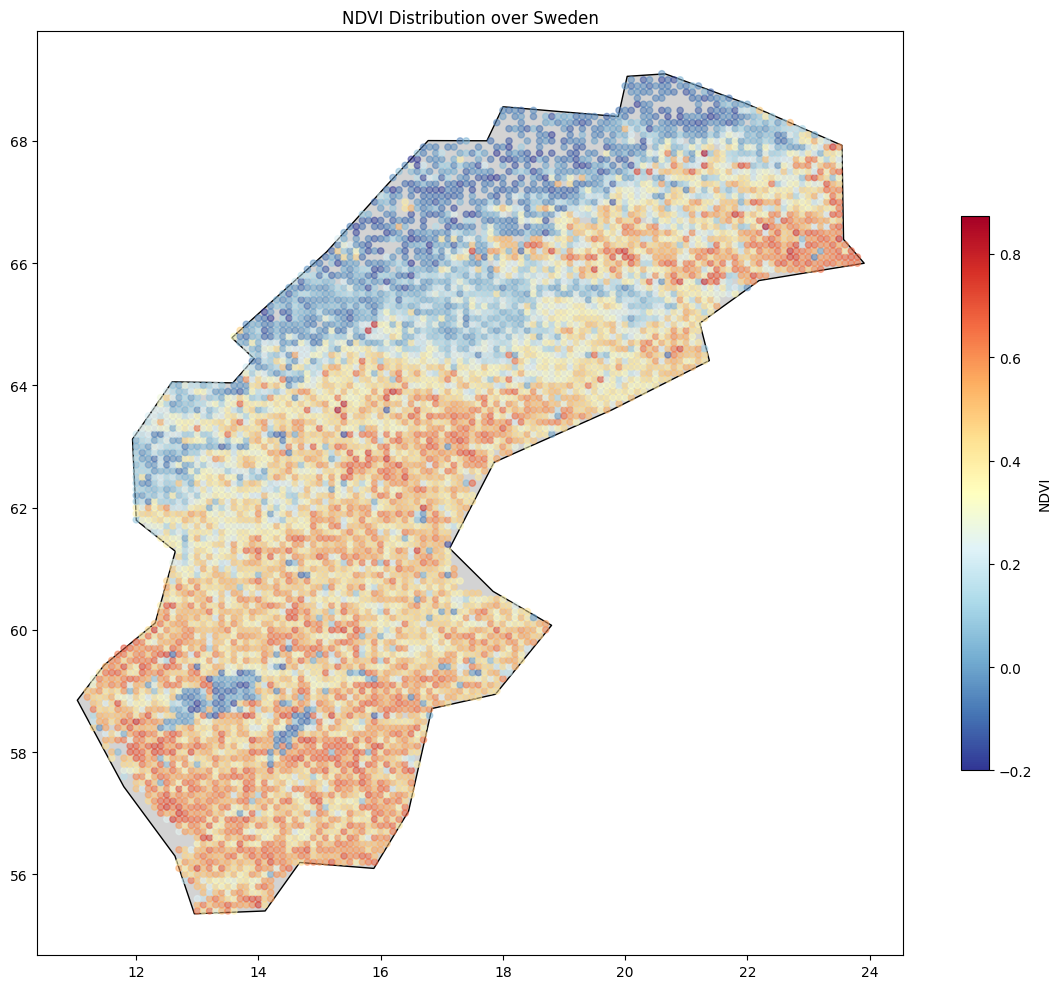

In [11]:
plot_heatmap_on_map(ndvi_features, 'NDVI_lag2', 'NDVI')

In [12]:
if save: ndvi_features.to_csv('../data/ndvi/ndvi_' + str(end.day) + '_' + str(end.month) + '_' + str(end.year) + '_.csv', index=False)

# Add to Hopsworks

In [16]:
ndvi_features.drop(columns=['NDVI', 'row_id'], inplace=True)

In [13]:
project = hopsworks.login()
fs = project.get_feature_store() 

2026-01-05 14:14:48,516 INFO: Initializing external client
2026-01-05 14:14:48,517 INFO: Base URL: https://c.app.hopsworks.ai:443




To ensure compatibility please install the latest bug fix release matching the minor version of your backend (4.2) by running 'pip install hopsworks==4.2.*'


2026-01-05 14:14:49,851 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1286351


In [17]:
# Retrieve feature groups
ndvi_fg = fs.get_feature_group(
    name='ndvi',
    version=1,
)

ndvi_fg.insert(ndvi_features)

Uploading Dataframe: 100.00% |██████████| Rows 7594/7594 | Elapsed Time: 00:03 | Remaining Time: 00:00


Launching job: ndvi_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1286351/jobs/named/ndvi_1_offline_fg_materialization/executions


(Job('ndvi_1_offline_fg_materialization', 'SPARK'), None)